<a href="https://colab.research.google.com/github/franciscogonzalez-gal/text_image_recognition/blob/main/Proyecto_Text_Mining_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final

**Nombre:** Francisco Gonzalez

**Carnet:** 24002914

## Problema 1

### 1) Montar Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Librerías

In [ ]:
import re
from collections import Counter
import pandas as pd


In [ ]:
import spacy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])  # solo tokenizer + lemmatizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# spaCy trae su propia lista de stopwords en inglés
# Stopwords ampliadas (además de las de spaCy):
extra_stop = {
    "rt","via","http","https","co","amp",
    "u","ur","im","i'm","ive","i’ve","id","i’d","ill","i’ll","ya","yall","y'all",
    "btw","thx","pls","plz","omg","lol","lmao","rofl","haha","hehe","kk",
    "hey","hi","hello","yo","ok","okay","k","ty","gtg","brb","bbl","tbh","ikr","idk","bday"
}
stop_words = nlp.Defaults.stop_words | extra_stop

### Ruta al archivo en tu carpeta "datos"

In [ ]:
# Ajusta el nombre del archivo CSV según corresponda
DATASET_PATH = '/content/drive/My Drive/datos/tw_source.csv'

### Parámetros


In [ ]:
CHUNKSIZE = 200_000
MENTION_RE = re.compile(r'@([A-Za-z0-9_]{1,15})')
WINDOW = 5
COLS = ['sentiment','id','date','query','user','text']
OUT_DIR = '/content/drive/My Drive/datos'


### Encontrar Top 3 usuarios más mencionados

In [ ]:
COLS = ['sentiment','id','date','query','user','text']

df = pd.read_csv(
    DATASET_PATH,
    header=None,
    names=COLS,
    encoding='latin-1',
    quotechar='"',
    escapechar='\\',
    engine='python',
    on_bad_lines='skip'   # salta filas rotas
)

print(df.shape)
print(df.head())
print(df.isna().sum())

(1599488, 6)
   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64


In [ ]:
mentions_series = df['text'].astype(str).str.findall(MENTION_RE)
mention_counts = Counter(m.lower() for lst in mentions_series for m in lst)
top3 = [u for u, _ in mention_counts.most_common(3)]
print("Top 3 usuarios más mencionados:", [f"@{u}" for u in top3])
print("Frecuencias:", [mention_counts[u] for u in top3])

Top 3 usuarios más mencionados: ['@mileycyrus', '@tommcfly', '@ddlovato']
Frecuencias: [4579, 3904, 3474]


### Construcción de corpus y contexto

In [ ]:
# Subcadenas del handle objetivo, para excluir alias como "miley", "cyrus", etc.
def handle_substrings(handle: str, minlen: int = 3):
    s = re.sub(r'[^a-z0-9]', '', handle.lower())
    subs = set()
    for i in range(len(s)):
        for j in range(i + minlen, len(s) + 1):
            subs.add(s[i:j])
    return subs

# POS que conservamos
KEEP_POS = {"NOUN", "VERB", "ADJ"}

# Normalización de repeticiones ("goooood" -> "good")
repeat_re = re.compile(r'(.)\1{2,}', re.IGNORECASE)
def deelongate(w: str) -> str:
    return repeat_re.sub(r'\1\1', w)

def clean_and_filter(tokens, block_set):
    tmp = []
    for t in tokens:
        t = t.lower().strip()
        if not t:
            continue
        if t.startswith('http://') or t.startswith('https://'):
            continue
        if t.startswith('@') or t.startswith('#'):
            t = t[1:]
        t = deelongate(t)
        if len(t) <= 2 or not re.search('[a-z]', t):
            continue
        if t in stop_words or t in block_set:
            continue
        tmp.append(t)

    # Lematización + POS con spaCy
    doc = nlp(" ".join(tmp))
    out = []
    for tok in doc:
        if tok.pos_ not in KEEP_POS:
            continue
        lemma = tok.lemma_.lower().strip()
        if not lemma or lemma in stop_words or lemma in block_set:
            continue
        if not lemma.isalpha() or len(lemma) <= 2:
            continue
        out.append(lemma)
    return out



In [ ]:
# 4) Construcción de corpus y contexto
corpora = {u: [] for u in top3}
# Conteo por DF
context_df_counts = {u: Counter() for u in top3}

# Precalcula subcadenas a bloquear por usuario (derivadas del handle)
handle_blocks = {u: handle_substrings(u) for u in top3}

In [ ]:
for row in df.itertuples(index=False):
    text = str(row.text)

    # Menciones del tweet (con y sin @)
    mentions = {m.lower() for m in MENTION_RE.findall(text)}
    mentions_no_at = {m.lstrip('@') for m in mentions}

    # ¿Qué targets aparecen en este tweet?
    found_targets = [u for u in top3 if u in mentions]
    if not found_targets:
        continue

    # Tokenización completa para longitud e índices de @u
    doc_full = nlp(text)
    tokens = [t.text for t in doc_full]
    length_tokens = len(tokens)

    for u in found_targets:
        # Guardar corpus
        corpora[u].append({
            'id': str(row.id),
            'timestamp': row.date,
            'length': length_tokens,
            'text': text
        })

        # Bloqueo base: subcadenas del handle + todas las menciones del tweet
        block_set = set()
        block_set |= handle_blocks[u]
        block_set |= mentions
        block_set |= mentions_no_at

        # Contexto alrededor de cada aparición del objetivo
        indices = [k for k, t in enumerate(tokens) if t.lower() == f'@{u}']
        if not indices:
            continue

        tweet_terms = set()
        for k in indices:
            start = max(0, k - WINDOW)
            end = min(len(tokens), k + WINDOW + 1)

            # Ventana original con mayúsculas para detectar PROPN
            window_tokens_orig = tokens[start:k] + tokens[k+1:end]
            window_doc = nlp(" ".join(window_tokens_orig))

            # Añade a bloque todos los PROPN en la ventana (nombres propios y alias)
            for wd in window_doc:
                if wd.pos_ == "PROPN":
                    block_set.add(wd.text.lower())

            # Pasa por limpieza/lemmatización y acumula DF por tweet
            cleaned = clean_and_filter([w.text for w in window_doc], block_set)
            tweet_terms.update(cleaned)

        context_df_counts[u].update(tweet_terms)

### Mostrar Top-10 (DF) y WordClouds

In [ ]:
for u in top3:
    print(f"\n@{u} – Top 10 palabras de contexto (DF):")
    for w, c in context_df_counts[u].most_common(10):
        print(f"  {w}: {c}")


@mileycyrus – Top 10 palabras de contexto (DF):
  love: 275
  vote: 231
  good: 160
  come: 137
  feel: 79
  luck: 79
  wish: 76
  hope: 73
  know: 69
  look: 66

@tommcfly – Top 10 palabras de contexto (DF):
  good: 123
  come: 103
  love: 98
  think: 78
  reply: 74
  miss: 72
  guy: 71
  want: 62
  birthday: 61
  know: 60

@ddlovato – Top 10 palabras de contexto (DF):
  love: 173
  wish: 137
  come: 99
  good: 77
  want: 71
  wait: 67
  hope: 63
  know: 58
  vote: 52
  fun: 41


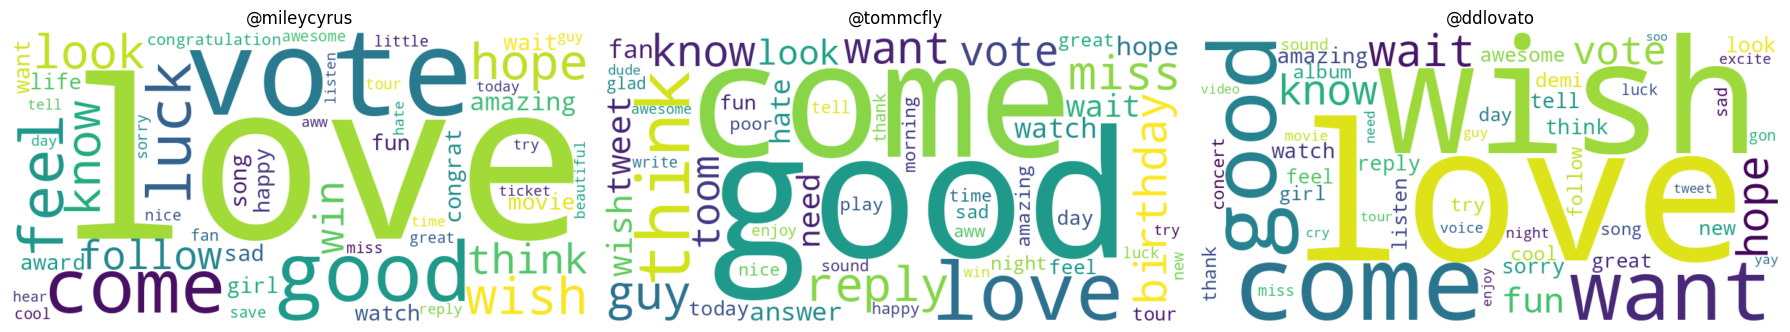

In [ ]:
# WordClouds basadas en DF
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(1, len(top3), figsize=(6*len(top3), 5))
if len(top3) == 1:
    axes = [axes]
for ax, u in zip(axes, top3):
    freqs = dict(context_df_counts[u].most_common(50)) or {'no_data': 1}
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(freqs)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'@{u}')
plt.tight_layout()
plt.show()

### Guardar corpus

In [ ]:
for u in top3:
    df_u = pd.DataFrame(corpora[u], columns=['id','timestamp','length','text'])
    out_path = f'{OUT_DIR}/corpus_{u}.csv'
    df_u.to_csv(out_path, index=False, encoding='utf-8')
    print(f'Corpus @{u} guardado en {out_path} con {len(df_u)} tweets')

Corpus @mileycyrus guardado en /content/drive/My Drive/datos/corpus_mileycyrus.csv con 4561 tweets
Corpus @tommcfly guardado en /content/drive/My Drive/datos/corpus_tommcfly.csv con 3898 tweets
Corpus @ddlovato guardado en /content/drive/My Drive/datos/corpus_ddlovato.csv con 3460 tweets


## Problema 2

In [1]:
import os, glob, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


### 1) Montar Drive y definir rutas

In [2]:



# Ajusta la ruta base si tu carpeta difiere
BASE_DIR = '/content/drive/MyDrive/datos/proyecto_image/Fruits_Vegetables_Dataset(12000)'
FRUITS_DIR = os.path.join(BASE_DIR, 'Fruits')
VEGGIES_DIR = os.path.join(BASE_DIR, 'Vegetables')

assert os.path.isdir(FRUITS_DIR), f"No existe {FRUITS_DIR}"
assert os.path.isdir(VEGGIES_DIR), f"No existe {VEGGIES_DIR}"

### 2) Construir listado de archivos y etiquetas


In [3]:
# =========================================================
#    - Las clases son las carpetas hijas de Fruits y Vegetables
# =========================================================
# 1) Directorios de clases
def list_class_dirs(root):
    return sorted([d for d in glob.glob(os.path.join(root, '*')) if os.path.isdir(d)])

FRUITS_DIR = os.path.join(BASE_DIR, 'Fruits')
VEGGIES_DIR = os.path.join(BASE_DIR, 'Vegetables')
fruit_classes = list_class_dirs(FRUITS_DIR)
veggie_classes = list_class_dirs(VEGGIES_DIR)
class_dirs = fruit_classes + veggie_classes

class_names = [os.path.basename(d) for d in class_dirs]
class_to_idx = {c:i for i, c in enumerate(class_names)}
num_classes = len(class_names)
print("Clases detectadas:", num_classes)
print(class_names)

# 2) Recolectar TODOS los archivos (válidos y no válidos)
VALID_EXTS_LOWER = ('.jpg', '.jpeg', '.png', '.bmp')  # extensiones aceptadas por tf.image.decode_image

def is_valid_ext(path):
    return path.lower().endswith(VALID_EXTS_LOWER)

rows_all = []
for cdir in class_dirs:
    cname = os.path.basename(cdir)
    for f in os.listdir(cdir):
        fpath = os.path.join(cdir, f)
        if os.path.isfile(fpath):
            rows_all.append((fpath, cname, class_to_idx[cname], is_valid_ext(fpath)))

df_all = pd.DataFrame(rows_all, columns=['filepath','classname','label','valid_ext'])

# 3) Reporte de conteos
total_all = len(df_all)
total_valid = int(df_all['valid_ext'].sum())
total_invalid = total_all - total_valid
print(f"Total archivos encontrados: {total_all}")
print(f"Válidos por extensión:      {total_valid}")
print(f"No válidos por extensión:   {total_invalid}")

# Conteo por clase
per_class = df_all.groupby(['classname','valid_ext']).size().unstack(fill_value=0).rename(columns={False:'no_validos', True:'validos'})
print("\nConteo por clase (válidos / no válidos):")
display(per_class)

# 4) Nos quedamos SOLO con los válidos para el entrenamiento
df = df_all[df_all['valid_ext']].drop(columns=['valid_ext']).reset_index(drop=True)
print("\nImágenes válidas que se usarán:", len(df))

Clases detectadas: 20
['FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry', 'RottenApple', 'RottenBanana', 'RottenMango', 'RottenOrange', 'RottenStrawberry', 'FreshBellpepper', 'FreshCarrot', 'FreshCucumber', 'FreshPotato', 'FreshTomato', 'RottenBellpepper', 'RottenCarrot', 'RottenCucumber', 'RottenPotato', 'RottenTomato']
Total archivos encontrados: 12000
Válidos por extensión:      11986
No válidos por extensión:   14

Conteo por clase (válidos / no válidos):


valid_ext,no_validos,validos
classname,,
FreshApple,0,612
FreshBanana,1,623
FreshBellpepper,0,611
FreshCarrot,1,619
FreshCucumber,0,608
FreshMango,0,605
FreshOrange,0,609
FreshPotato,1,614
FreshStrawberry,0,603



Imágenes válidas que se usarán: 11986


### 3) División estratificada: 70% train, 15% val, 15% test


In [4]:

train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42
)

print(f"train: {len(train_df)} | val: {len(val_df)} | test: {len(test_df)}")


train: 8390 | val: 1798 | test: 1798


### 4) Parámetros de entrada, augmentations y canal de datos tf.data


In [5]:


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.one_hot(label, num_classes)

def make_dataset(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(4096, seed=42)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    # Si quedara algún archivo problemático, no detiene el entrenamiento
    try:
        ds = ds.apply(tf.data.experimental.ignore_errors())
    except AttributeError:
        ds = ds.ignore_errors()
    return ds

train_ds = make_dataset(train_df['filepath'].values, train_df['label'].values, training=True)
val_ds   = make_dataset(val_df['filepath'].values,   val_df['label'].values,   training=False)
test_ds  = make_dataset(test_df['filepath'].values,  test_df['label'].values,  training=False)

print("Datasets listos.")

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Datasets listos.


### 5) Definir tres arquitecturas


In [6]:

def build_cnn_basica(input_shape=(224,224,3), n_classes=num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='CNN_Basica')
    return model

def build_cnn_bn_do(input_shape=(224,224,3), n_classes=num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='CNN_BN_Dropout')
    return model

def build_mobilenetv2(input_shape=(224,224,3), n_classes=num_classes):
    # Backbone preentrenado
    base = keras.applications.MobileNetV2(
        input_shape=input_shape, include_top=False, weights='imagenet'
    )
    base.trainable = False  # luego podemos afinar

    inputs = layers.Input(shape=input_shape)

    # Tu dataset ya está en [0,1]. Lo mapeamos a [-1,1] como espera MobileNetV2.
    # Equivalente a preprocess_input pero partiendo de [0,1].
    x = layers.Rescaling(2.0, offset=-1.0)(inputs)  # 0..1 -> -1..1

    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='MobileNetV2_transfer')
    return model


### 6) Funciones de entrenamiento y evaluación


In [7]:

def compile_model(model, lr=1e-3):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

def train_model(model, train_ds, val_ds, epochs=12):
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy', patience=3, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=2, verbose=1
        )
    ]
    history = model.fit(
        train_ds, validation_data=val_ds, epochs=epochs, verbose=1, callbacks=callbacks
    )
    return history

def plot_history(history, title):
    hist = history.history
    plt.figure(figsize=(6,4))
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.title(f'Pérdida - {title}'); plt.xlabel('Época'); plt.ylabel('Loss'); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist['accuracy'], label='train_acc')
    plt.plot(hist['val_accuracy'], label='val_acc')
    plt.title(f'Accuracy - {title}'); plt.xlabel('Época'); plt.ylabel('Acc'); plt.legend(); plt.show()

def evaluate_and_report(model, test_ds, class_names):
    y_true = []
    y_pred = []
    for x, y in test_ds:
        preds = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(y.numpy(), axis=1))
    y_true = np.array(y_true); y_pred = np.array(y_pred)

    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Matriz de confusión (test)')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('Real'); plt.xlabel('Predicho')
    plt.tight_layout(); plt.show()

### 7) Entrenamiento de las 3 arquitecturas


Epoch 1/15
    260/Unknown 37s 116ms/step - accuracy: 0.1034 - loss: 2.8798

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


260/260 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.1035 - loss: 2.8793 - val_accuracy: 0.2564 - val_loss: 2.4985 - learning_rate: 0.0010
Epoch 2/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.2490 - loss: 2.4537 - val_accuracy: 0.3560 - val_loss: 2.2050 - learning_rate: 0.0010
Epoch 3/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.3304 - loss: 2.1980 - val_accuracy: 0.4082 - val_loss: 1.9422 - learning_rate: 0.0010
Epoch 4/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - accuracy: 0.4024 - loss: 1.9559 - val_accuracy: 0.4477 - val_loss: 1.8343 - learning_rate: 0.0010
Epoch 5/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.4424 - loss: 1.8349 - val_accuracy: 0.4638 - val_loss: 1.8019 - learning_rate: 0.0010
Epoch 6/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - accuracy: 0.4683 - loss: 1.7286 - val_accuracy: 0.4978 - val_loss: 1.6255 - learning_rate: 0.0010
Epoch 7/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 51s 197ms/step - accuracy: 0.5104 - loss:

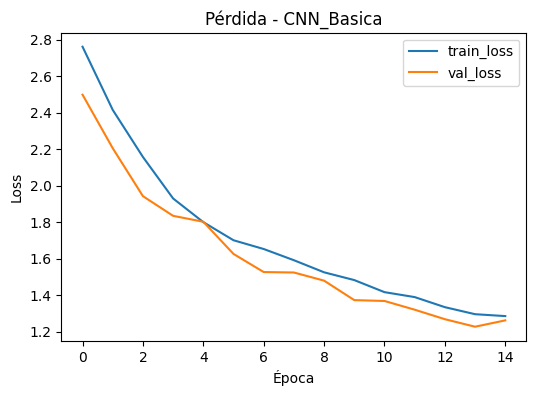

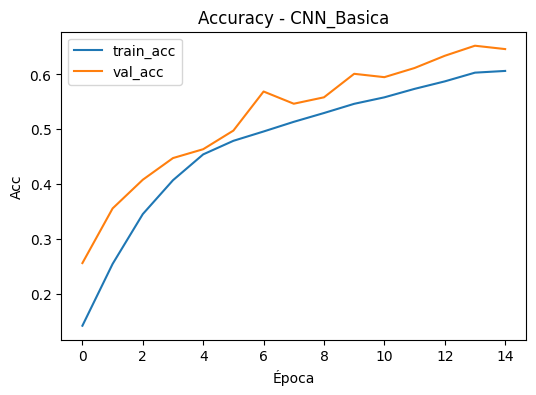

Test CNN_Basica: loss=1.1936, acc=0.6691
                  precision    recall  f1-score   support

      FreshApple     0.7789    0.8043    0.7914        92
     FreshBanana     0.7581    0.5054    0.6065        93
      FreshMango     0.7358    0.8571    0.7919        91
     FreshOrange     0.7576    0.8242    0.7895        91
 FreshStrawberry     0.6748    0.9121    0.7757        91
     RottenApple     0.6875    0.5000    0.5789        88
    RottenBanana     0.5949    0.5465    0.5697        86
     RottenMango     0.6750    0.6067    0.6391        89
    RottenOrange     0.6827    0.7978    0.7358        89
RottenStrawberry     0.6702    0.7079    0.6885        89
 FreshBellpepper     0.7816    0.7391    0.7598        92
     FreshCarrot     0.6071    0.7312    0.6634        93
   FreshCucumber     0.6087    0.9231    0.7336        91
     FreshPotato     0.7041    0.7500    0.7263        92
     FreshTomato     0.8451    0.6667    0.7453        90
RottenBellpepper     0.3678   

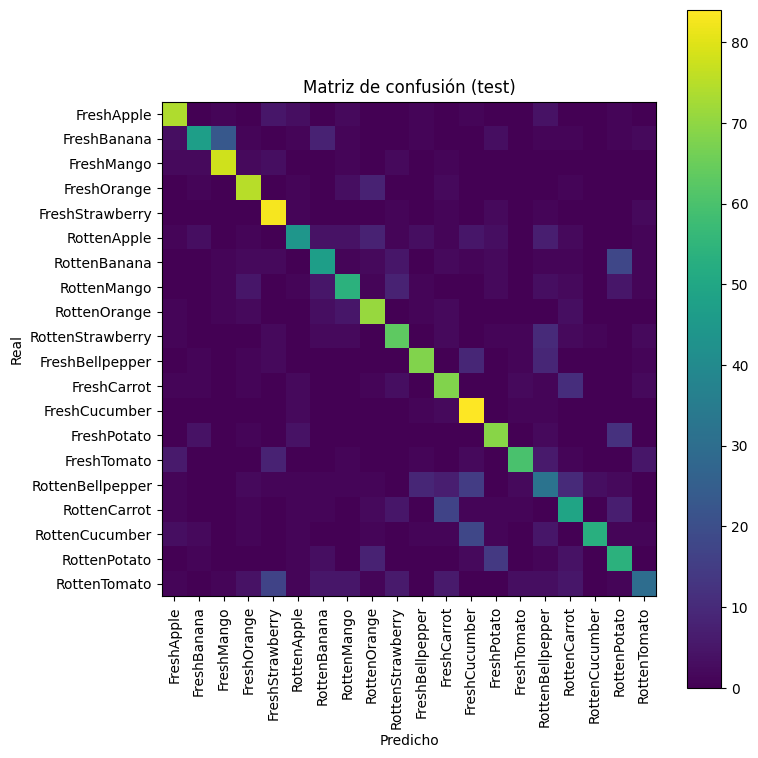

Epoch 1/20
    260/Unknown 42s 131ms/step - accuracy: 0.2449 - loss: 2.5278

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


260/260 ━━━━━━━━━━━━━━━━━━━━ 48s 153ms/step - accuracy: 0.2452 - loss: 2.5268 - val_accuracy: 0.0890 - val_loss: 4.7309 - learning_rate: 0.0010
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.4409 - loss: 1.8325 - val_accuracy: 0.4366 - val_loss: 1.8922 - learning_rate: 0.0010
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.5177 - loss: 1.5696 - val_accuracy: 0.5534 - val_loss: 1.4580 - learning_rate: 0.0010
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.5765 - loss: 1.4083 - val_accuracy: 0.5167 - val_loss: 1.8369 - learning_rate: 0.0010
Epoch 5/20
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6093 - loss: 1.2830
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.6093 - loss: 1.2829 - val_accuracy: 0.4338 - val_loss: 1.8017 - learning_rate: 0.0010
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.6572 - loss: 1

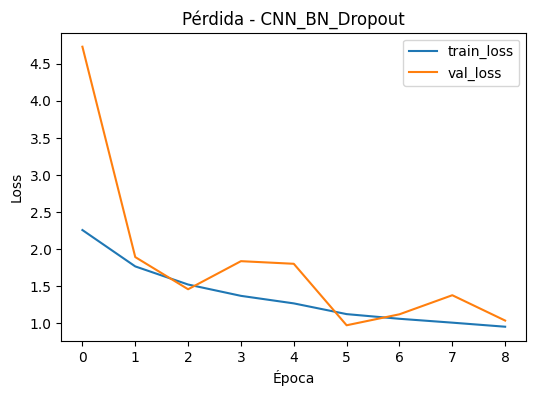

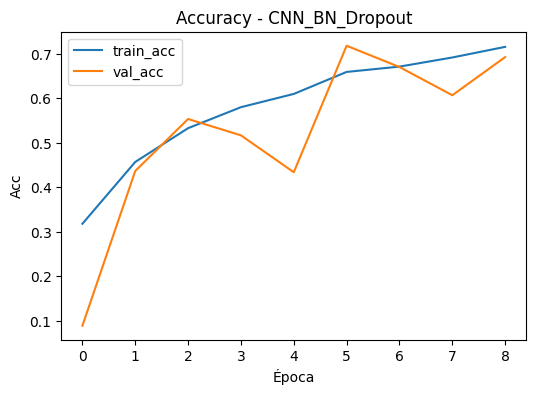

Test CNN_BN_Dropout: loss=0.9462, acc=0.7214
                  precision    recall  f1-score   support

      FreshApple     0.8600    0.9348    0.8958        92
     FreshBanana     0.7196    0.8280    0.7700        93
      FreshMango     0.8315    0.8132    0.8222        91
     FreshOrange     0.7624    0.8462    0.8021        91
 FreshStrawberry     0.7542    0.9780    0.8517        91
     RottenApple     0.8070    0.5227    0.6345        88
    RottenBanana     0.7045    0.7209    0.7126        86
     RottenMango     0.6092    0.5955    0.6023        89
    RottenOrange     0.9107    0.5730    0.7034        89
RottenStrawberry     0.7387    0.9213    0.8200        89
 FreshBellpepper     0.8529    0.6304    0.7250        92
     FreshCarrot     0.6364    0.9032    0.7467        93
   FreshCucumber     0.6694    0.9121    0.7721        91
     FreshPotato     0.7347    0.7826    0.7579        92
     FreshTomato     0.7097    0.7333    0.7213        90
RottenBellpepper     0.562

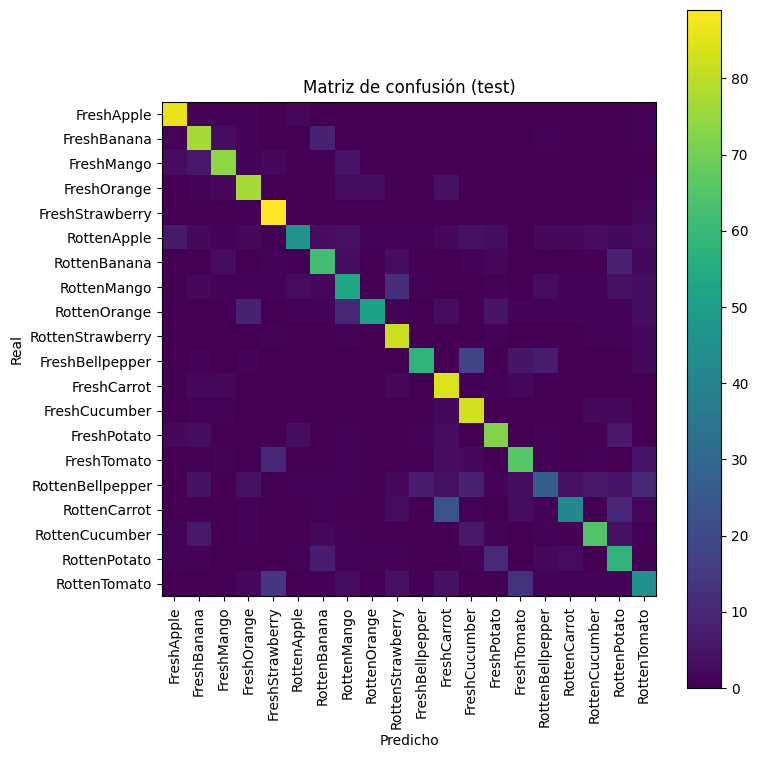

Epoch 1/12
    260/Unknown 58s 152ms/step - accuracy: 0.5742 - loss: 1.4374

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


260/260 ━━━━━━━━━━━━━━━━━━━━ 74s 213ms/step - accuracy: 0.5749 - loss: 1.4352 - val_accuracy: 0.8737 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 2/12
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.8920 - loss: 0.3619 - val_accuracy: 0.8999 - val_loss: 0.3102 - learning_rate: 0.0010
Epoch 3/12
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.9164 - loss: 0.2763 - val_accuracy: 0.9188 - val_loss: 0.2466 - learning_rate: 0.0010
Epoch 4/12
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.9293 - loss: 0.2302 - val_accuracy: 0.9366 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 5/12
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.9277 - loss: 0.2160 - val_accuracy: 0.9394 - val_loss: 0.2035 - learning_rate: 0.0010
Epoch 6/12
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 109ms/step - accuracy: 0.9463 - loss: 0.1719 - val_accuracy: 0.9416 - val_loss: 0.1999 - learning_rate: 0.0010
Epoch 7/12
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.9488 - loss:

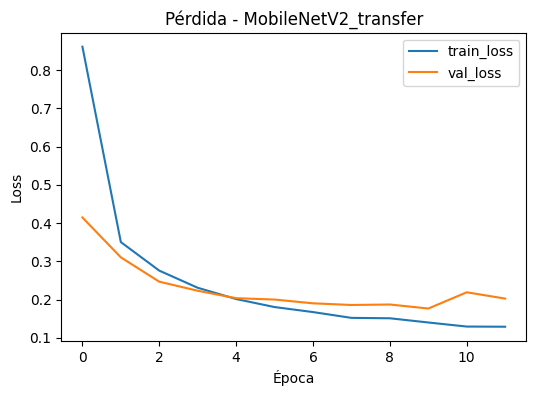

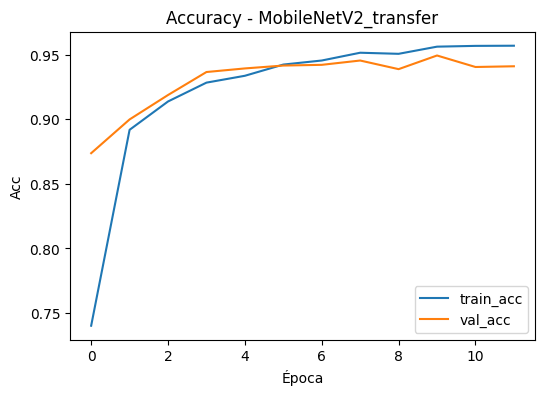

Test MobileNetV2_transfer: loss=0.9462, acc=0.7214
                  precision    recall  f1-score   support

      FreshApple     0.9677    0.9783    0.9730        92
     FreshBanana     1.0000    1.0000    1.0000        93
      FreshMango     0.9479    1.0000    0.9733        91
     FreshOrange     0.9783    0.9890    0.9836        91
 FreshStrawberry     0.9891    1.0000    0.9945        91
     RottenApple     0.8571    0.8864    0.8715        88
    RottenBanana     0.9770    0.9884    0.9827        86
     RottenMango     0.9540    0.9326    0.9432        89
    RottenOrange     0.9762    0.9213    0.9480        89
RottenStrawberry     1.0000    0.9663    0.9829        89
 FreshBellpepper     0.9341    0.9239    0.9290        92
     FreshCarrot     0.9263    0.9462    0.9362        93
   FreshCucumber     0.9474    0.9890    0.9677        91
     FreshPotato     0.9082    0.9674    0.9368        92
     FreshTomato     0.9778    0.9778    0.9778        90
RottenBellpepper    

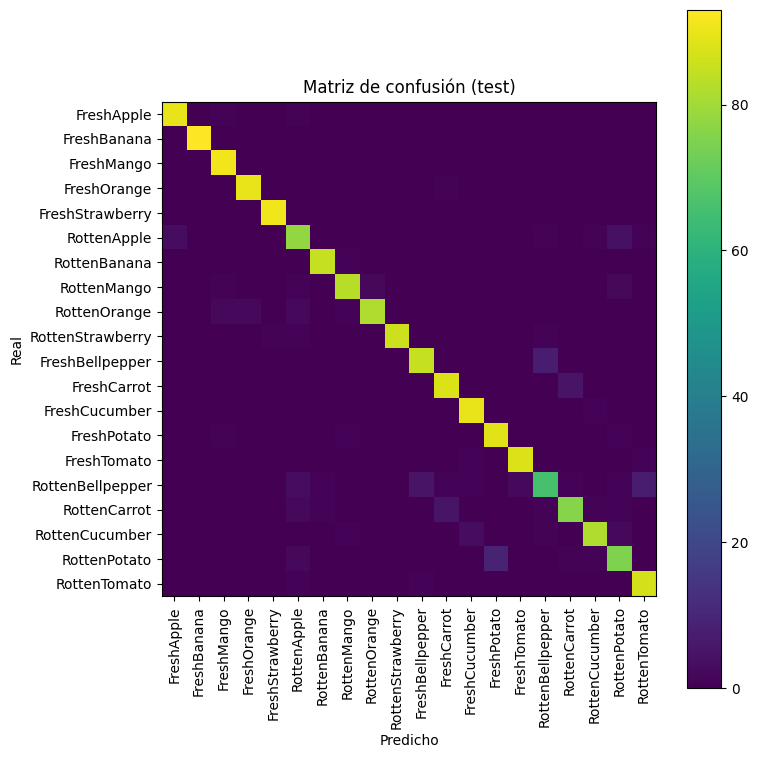

In [8]:

results = []

# Modelo A: CNN básica
model_a = build_cnn_basica()
compile_model(model_a, lr=1e-3)
hist_a = train_model(model_a, train_ds, val_ds, epochs=15)
plot_history(hist_a, model_a.name)
test_loss, test_acc = model_a.evaluate(test_ds, verbose=0)
print(f"Test {model_a.name}: loss={test_loss:.4f}, acc={test_acc:.4f}")
results.append((model_a.name, test_acc))
evaluate_and_report(model_a, test_ds, class_names)

# Modelo B: CNN con BatchNorm + Dropout
model_b = build_cnn_bn_do()
compile_model(model_b, lr=1e-3)
hist_b = train_model(model_b, train_ds, val_ds, epochs=20)
plot_history(hist_b, model_b.name)
test_loss, test_acc = model_b.evaluate(test_ds, verbose=0)
print(f"Test {model_b.name}: loss={test_loss:.4f}, acc={test_acc:.4f}")
results.append((model_b.name, test_acc))
evaluate_and_report(model_b, test_ds, class_names)

# Modelo C: Transfer Learning MobileNetV2
model_c = build_mobilenetv2()
compile_model(model_c, lr=1e-3)
hist_c = train_model(model_c, train_ds, val_ds, epochs=12)
plot_history(hist_c, model_c.name)
print(f"Test {model_c.name}: loss={test_loss:.4f}, acc={test_acc:.4f}")
results.append((model_c.name, test_acc))
evaluate_and_report(model_c, test_ds, class_names)

### 8) Guardar modelos


In [11]:


SAVE_DIR = '/content/drive/MyDrive/modelos_frutas_verduras'
os.makedirs(SAVE_DIR, exist_ok=True)

model_a.save(f'{SAVE_DIR}/{model_a.name}.keras')
model_b.save(f'{SAVE_DIR}/{model_b.name}.keras')
model_c.save(f'{SAVE_DIR}/{model_c.name}.keras')

### 9) Conclusiones del experimento



**Resumen general.** Se evaluaron tres enfoques de clasificación para 18 clases (fresco/podrido por fruta/verdura).  
Los resultados en prueba muestran que **Transfer Learning con MobileNetV2** es claramente superior (**accuracy ≈ 0.943, macro-F1 ≈ 0.942**),  
seguido por la **CNN con BatchNorm + Dropout** (**accuracy ≈ 0.721, macro-F1 ≈ 0.711**) y, por último, la **CNN básica**  
(**accuracy ≈ 0.669, macro-F1 ≈ 0.662**). La diferencia se debe a que MobileNetV2 reutiliza representaciones preentrenadas en ImageNet,  
más robustas a escala, rotación e iluminación, mientras que las CNN desde cero requieren más datos para alcanzar un nivel comparable.

**Comparación por modelo**

- **MobileNetV2 (transfer learning):** mejor equilibrio entre precisión y recall, especialmente en clases “fresh”.  
  Las mayores dificultades aparecen en algunas clases “rotten” (ej. bellpepper), donde los patrones de pudrición son más variables.  
  Con *fine-tuning* de las últimas capas y un *learning rate* bajo es posible mejorar aún más el rendimiento.
- **CNN con BatchNorm + Dropout:** supera a la CNN básica gracias a la regularización,  
  pero sigue mostrando confusiones en varias clases “rotten” (p. ej. rotten bellpepper, rotten tomato).
- **CNN básica:** desempeño más limitado; presenta sobreajuste y mayor confusión en texturas degradadas,  
  lo que afecta sobre todo a las clases “rotten”.

**Observaciones por clases**

- Las categorías **“fresh”** tienen métricas altas y consistentes, lo que indica que la morfología y color característicos son bien capturados.  
- Las categorías **“rotten”** son más difíciles por su variabilidad intra-clase (diferentes patrones de pudrición, iluminación y fondo).  
  MobileNetV2 mantiene ventaja, aunque aún muestra confusión en ciertas clases específicas.

**Aspectos de entrenamiento y validación**

- El *data augmentation* geométrico (flip, rotación, zoom) ayudó a la generalización.  
  Para las clases “rotten” se recomienda añadir aumentos fotométricos (brillo, contraste, saturación).  
- La **normalización coherente** con MobileNetV2 (escalar de [0,1] a [-1,1]) fue clave para evitar pérdida de rendimiento.  
- La división estratificada 70/15/15 permitió comparaciones justas y sin fugas de distribución.

**Recomendaciones prácticas**

1. Adoptar **MobileNetV2** como modelo base y realizar *fine-tuning* de las últimas 20–30 capas con *learning rate* bajo (≈1e-4).  
2. Incrementar el *data augmentation* fotométrico y aplicar **class weights** u **oversampling** en clases “rotten”.  
3. Considerar aumentar la resolución de entrada (256–299 px) si los recursos lo permiten.  
4. Evaluar métricas como **macro-F1** además de accuracy, ya que reflejan mejor el desempeño en clases difíciles.  
5. Guardar el modelo en formato **`.keras`** (recomendado) y explorar exportación a **TFLite** para despliegue en dispositivos de bajo consumo.

---

**Conclusión final.** Con el preprocesamiento correcto, **MobileNetV2** ofrece un rendimiento alto y consistente en la clasificación de frutas y verduras frescas/podridas.  
Las mejoras sugeridas (fine-tuning, aumentos fotométricos y balanceo de clases) consolidarían aún más su ventaja frente a arquitecturas entrenadas desde cero  
y aumentarían la robustez en las clases “rotten”, que representan el mayor desafío del problema.
